In [78]:
# Code aus "Neuronale Netze selbst programmieren,
# ein verständlicher Einstieg mit Python"
# von Tariq Rashid , O'Reilly
# license GPLv2

import numpy
# scipy.special for the sigmoid function expit()
import scipy.special
import matplotlib.pyplot
%matplotlib inline
import os
# helper to load data from PNG image files
import imageio
# glob helps select multiple files using patterns
import glob

In [38]:
# neural network class definition
class neuralNetwork:

    # initialise the neural network
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        # set number of nodes in each inpzt, hidden oputput layer
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes

        # learning rate
        self.lr = learningrate

        # link weight matrices, wih and who 
        # weights inside the arrays aer w_i_j, where link is from node i to node j in the next layer
        self.wih = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.hnodes, self.inodes))
        self.who = numpy.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))
        
        # acitivation function is the sigmoid funciton
        self.activation_function = lambda x: scipy.special.expit(x)
    
        pass
    
    # train the neural network
    def train(self, inputs_list, targets_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T
        targets = numpy.array(targets_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final output layer
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        
        # output layer error is the (target - actual)
        output_errors = targets - final_outputs
        # hidden layer error is the output_errors, split by weights, recombined at hidden nodes
        hidden_errors = numpy.dot(self.who.T, output_errors)
        
        # update the weights for the links between the hidden and output layers
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))
        
        # update the weights for the links between the input and hidden layers
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))
        
        pass

    # query the neural network
    def query(self, inputs_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T
        
        # calculate signals into hidden layer        
        hidden_inputs = numpy.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)      
        
        # calculate signals final output layer        
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # calculate the signals emerging final output layer
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs


In [39]:
# number of input, hidden and output nodes
input_nodes = 784
hidden_nodes = 100
output_nodes = 10

# learning rate
learning_rate = 0.3

# create instance of neural network
n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

In [76]:
# https://stackoverflow.com/questions/7165749/open-file-in-a-relative-location-in-python
# relative path to files
fileDir = os.path.dirname(os.path.realpath('__file__'))
# For accessing the file in the parent folder of the current folder
# small test data for quick calculations
#training_data_path = os.path.join(fileDir, '../../trainingdata/testdata_mnist/mnist_train_100.csv')
#test_data_path = os.path.join(fileDir, '../../trainingdata/testdata_mnist/mnist_test_10.csv')
# real test data (60'000 training data / 10'000 test data)
training_data_path = os.path.join(fileDir, '../../trainingdata/testdata_mnist/mnist_train.csv')
test_data_path = os.path.join(fileDir, '../../trainingdata/testdata_mnist/mnist_test.csv') 
test_data_png = os.path.join(fileDir, '../../trainingdata/testdata_mnist/2828_my_own_?.png') 

In [50]:
# load mnist training csv file into a list
training_data_file = open(training_data_path, 'r')
training_data_list = training_data_file.readlines()
training_data_file.close()

In [51]:
# train the neural network
# epochs is the number of times the training data set is used for training
epochs = 1

for e in range(epochs):
    # go through all records in the training data set
    for record in training_data_list:
        # split the record by the ',' commas
        all_values = record.split(',')
        # scale input to range 0.01 to 1.00
        inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        # create the target output values (all 0.01, except the desired label which is 0.99)
        targets = numpy.zeros(output_nodes) + 0.01
        # all_values[0] is the target label for this record
        targets[int(all_values[0])] = 0.99
        n.train(inputs, targets)
        pass
    pass

In [52]:
# load mnist test csv file into a list
test_data_file = open(test_data_path, 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

In [68]:
#get the first test record
all_values = test_data_list[1].split(',')
# print the label
print(all_values[0]) 

2


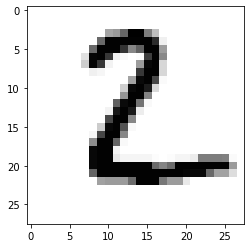

In [69]:
image_array = numpy.asfarray(all_values[1:]).reshape((28,28))
matplotlib.pyplot.imshow(image_array, cmap='Greys', interpolation='None')

In [70]:
n.query((numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01)

array([[1.65473837e-02],
       [5.80011380e-03],
       [9.97442390e-01],
       [1.90289774e-02],
       [9.81732523e-04],
       [1.75999931e-03],
       [3.30384588e-03],
       [6.92703868e-04],
       [6.56228707e-05],
       [1.88403636e-04]])

In [71]:
# test the neural network
# scorecard for how well the network performs
scorecard = []

# go through all the records in the test data set
for record in test_data_list:
    # split the record by the ',' commas
    all_values = record.split(',')
    # correct answer is first value
    correct_label = int(all_values[0])
    # scale input to range 0.01 to 1.00
    inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    # query the network
    outputs = n.query(inputs)
    # the index of the highest value corresponds to the label
    label = numpy.argmax(outputs)
    # append correct or incorrect to list
    if (label == correct_label):
        # network's answer matches correct answer, add 1 to scorecard
        scorecard.append(1)
    else:
        # network's answer doesn't match correct answer, add 0 to scorecard
        scorecard.append(0)
        pass
    
    pass

In [72]:
# calculate the performance score (correct answers/ all answers)
scorecard_array = numpy.asarray(scorecard)
print ("performance = ", scorecard_array.sum() / scorecard_array.size)

performance =  0.9409


In [73]:
print(image_file_name[-5:-4])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [80]:
# our own image test data set
our_own_dataset = []

# load the png image data as test data set
for image_file_name in glob.glob(test_data_png):
    
    # use the filename to set the correct label
    label = int(image_file_name[-5:-4])
    
    # load image data from png files into an array
    print ("loading ... ", image_file_name)
    img_array = imageio.imread(image_file_name, as_gray=True)
    
    # reshape from 28x28 to list of 784 values, invert values
    img_data  = 255.0 - img_array.reshape(784)
    
    # then scale data to range from 0.01 to 1.0
    img_data = (img_data / 255.0 * 0.99) + 0.01
    print(numpy.min(img_data))
    print(numpy.max(img_data))
    
    # append label and image data  to test data set
    record = numpy.append(label,img_data)
    our_own_dataset.append(record)
    
    pass

loading ...  3
0.01
1.0


[[2.26119714e-03]
 [1.88758653e-02]
 [7.92301475e-03]
 [9.70859268e-01]
 [2.68825063e-03]
 [1.20350202e-02]
 [2.31435804e-03]
 [2.20656573e-02]
 [5.88354372e-04]
 [8.68720067e-04]]
network says  3
match!


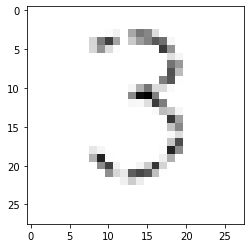

In [83]:
# test the neural network with our own images

# record to test
item = 0

# plot image
matplotlib.pyplot.imshow(our_own_dataset[item][1:].reshape(28,28), cmap='Greys', interpolation='None')

# correct answer is first value
correct_label = our_own_dataset[item][0]
# data is remaining values
inputs = our_own_dataset[item][1:]

# query the network
outputs = n.query(inputs)
print (outputs)

# the index of the highest value corresponds to the label
label = numpy.argmax(outputs)
print("network says ", label)
# append correct or incorrect to list
if (label == correct_label):
    print ("match!")
else:
    print ("no match!")
    pass